In [1]:
# LSCA-GAN: Latent Space Contrastive Alignment GAN (PyTorch)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import os

In [2]:
# --- Hyperparameters ---
batch_size = 128
latent_dim = 100
image_size = 28
lambda_contrastive = [0.0, 1.0, 2.0, 3.0, 4.0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# --- Data ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.30MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.69MB/s]


In [4]:
# --- Pretrain Feature Encoder ---
class FeatureEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

    def forward(self, x):
        return self.features(x).view(x.size(0), -1)

encoder = FeatureEncoder().to(device)

# Simple classifier head for supervised pretraining
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(64, 10)
    def forward(self, x):
        return self.linear(x)

classifier = Classifier().to(device)

encoder_path = "/content/drive/My Drive/pretrained_encoder.pth"
classifier_path = "/content/drive/My Drive/pretrained_classifier.pth"

In [5]:
# prompt: mount on drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
if os.path.exists(encoder_path) and os.path.exists(classifier_path):
    encoder.load_state_dict(torch.load(encoder_path))
    classifier.load_state_dict(torch.load(classifier_path))
else:
    optimizer_enc = torch.optim.Adam(encoder.parameters(), lr=1e-3)
    optimizer_cls = torch.optim.Adam(classifier.parameters(), lr=1e-3)
    loss_fn_enc = nn.CrossEntropyLoss()

    # Pretrain Encoder on MNIST
    encoder.train()
    classifier.train()
    for epoch in range(10):  # quick pretrain for demo
        for imgs, labels in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            feats = encoder(imgs)
            preds = classifier(feats)
            loss = loss_fn_enc(preds, labels)

            optimizer_enc.zero_grad()
            optimizer_cls.zero_grad()
            loss.backward()
            optimizer_enc.step()
            optimizer_cls.step()

    torch.save(encoder.state_dict(), encoder_path)
    torch.save(classifier.state_dict(), classifier_path)

In [10]:
encoder.eval()  # freeze encoder
for param in encoder.parameters():
    param.requires_grad = False

# --- Generator (CNN-based) ---
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# --- Discriminator (CNN-based) ---
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# --- Contrastive Loss ---
def contrastive_loss(z, temperature=0.5):
    z = F.normalize(z, dim=1)
    sim_matrix = torch.matmul(z, z.T)
    labels = torch.arange(z.size(0), device=z.device)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
    mask = torch.eye(z.size(0), device=z.device).bool()
    sim_matrix.masked_fill_(mask, -9e15)
    logits = sim_matrix / temperature
    log_prob = F.log_softmax(logits, dim=1)
    loss = -log_prob[labels.bool()].mean()
    return loss

# --- Training LSCA-GAN ---
def train_lsca_gan(lambda_c, epochs=1):
    G = Generator(latent_dim).to(device)
    D = Discriminator().to(device)
    optimizer_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        for real_imgs, _ in data_loader:
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)
            valid = torch.ones(batch_size, 1, device=device)
            fake = torch.zeros(batch_size, 1, device=device)

            # --- Train Discriminator ---
            z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            gen_imgs = G(z)
            real_loss = criterion(D(real_imgs), valid)
            fake_loss = criterion(D(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

            # --- Train Generator ---
            z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            gen_imgs = G(z)
            g_loss = criterion(D(gen_imgs), valid)
            if lambda_c > 0:
                features = encoder(gen_imgs)
                c_loss = contrastive_loss(features)
                g_loss += lambda_c * c_loss

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

    return G

# --- Visualization ---
def visualize_samples_and_latents(generator, lambda_val):
    generator.eval()
    z = torch.randn(10, latent_dim, 1, 1, device=device)
    with torch.no_grad():
        samples = generator(z).cpu()

    # Plot samples
    grid = make_grid(samples, nrow=5, normalize=True)
    plt.figure(figsize=(6, 3))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.title(f"Generated Samples (lambda={lambda_val})")
    plt.show()

    # Plot t-SNE of latent vectors
    # z_np = z.view(10, -1).cpu().numpy()
    # if z_np.shape[0] > 2:
    #     perplexity = min(5, z_np.shape[0] - 1)
    #     z_2d = TSNE(n_components=2, perplexity=perplexity).fit_transform(z_np)
    #     plt.figure(figsize=(4, 4))
    #     plt.scatter(z_2d[:, 0], z_2d[:, 1], c='blue')
    #     plt.title(f"t-SNE of Latent Vectors (lambda={lambda_val})")
    #     plt.show()

Model saved to /content/drive/My Drive/lsca_gan_model_0.0.pth


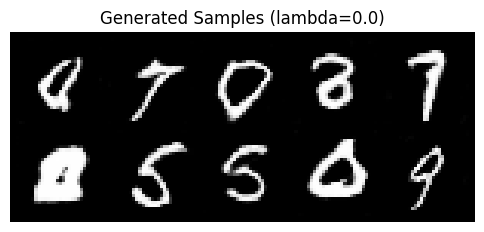

Model saved to /content/drive/My Drive/lsca_gan_model_1.0.pth


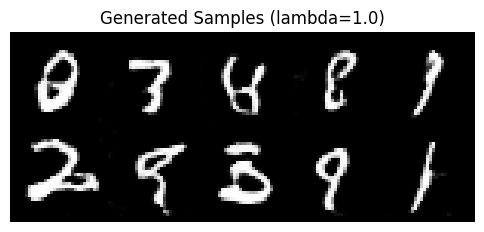

Model saved to /content/drive/My Drive/lsca_gan_model_2.0.pth


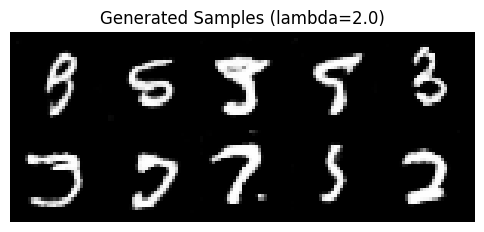

Model saved to /content/drive/My Drive/lsca_gan_model_3.0.pth


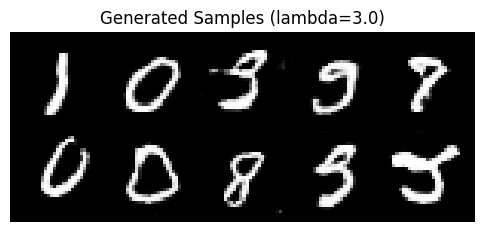

Model saved to /content/drive/My Drive/lsca_gan_model_4.0.pth


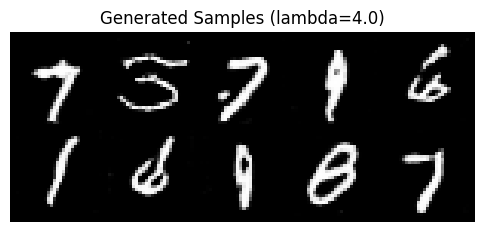

In [11]:
# --- Run for lambda = 0 and 1 ---
for lmbd in lambda_contrastive:
    gen = train_lsca_gan(lambda_c=lmbd, epochs=20)
    model_save_path = f"/content/drive/My Drive/lsca_gan_model_{lmbd}.pth"
    torch.save(gen.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")
    visualize_samples_and_latents(gen, lmbd)

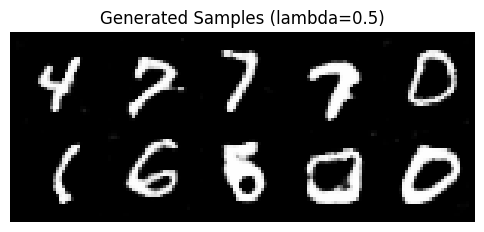

In [12]:
gen = train_lsca_gan(lambda_c=0.5, epochs=20)
visualize_samples_and_latents(gen, 0.5)
model_save_path = f"/content/drive/My Drive/lsca_gan_model_0.5.pth"
torch.save(gen.state_dict(), model_save_path)

In [20]:
# prompt: generate and save 1000 images on drive, generate using the generator model

import os
from PIL import Image

# ... (Your existing code) ...

generator = Generator(latent_dim)
generator.load_state_dict(torch.load("/content/drive/My Drive/lsca_gan_model_0.5.pth", map_location=torch.device('cpu')))
generator.eval()

def generate_and_save_images(generator, num_images=1000, save_dir="/content/drive/My Drive/generated_images"):
    os.makedirs(save_dir, exist_ok=True)
    generator.eval()
    for i in range(num_images):
        z = torch.randn(1, latent_dim, 1, 1, device=device)
        with torch.no_grad():
            sample = gen(z).cpu()
        grid = make_grid(sample, normalize=True)
        # Convert tensor to PIL image
        image = transforms.ToPILImage()(grid)

        #Save image
        image_path = os.path.join(save_dir, f"image_{i}.png")
        image.save(image_path)

# Example usage after training:
generate_and_save_images(gen) # Assuming 'gen' is your trained generator


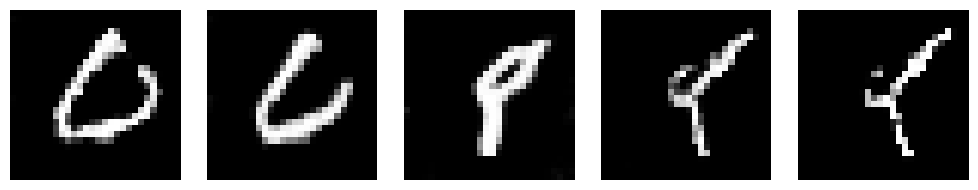

In [19]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np


# Load the saved generator model
z_dim = latent_dim
generator = Generator(latent_dim)
generator.load_state_dict(torch.load("/content/drive/My Drive/lsca_gan_model_0.5.pth", map_location=torch.device('cpu')))
generator.eval()

# Function to display generated images
def show_images(images, nrow=5):
    images = images.detach().cpu().numpy()
    fig, axes = plt.subplots(1, nrow, figsize=(nrow * 2, 2))
    for i in range(nrow):
        ax = axes[i]
        ax.imshow(images[i][0], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Sample a base latent vector
z_base = torch.randn(1, z_dim, 1, 1)

# Manipulate the latent vector along a specific direction
direction = torch.randn_like(z_base)  # Replace with a learned direction vector if available
alphas = torch.linspace(-3, 3, steps=5)  # Range of manipulations

# Generate images from manipulated latent vectors
z_variations = torch.cat([z_base + alpha * direction for alpha in alphas], dim=0)
with torch.no_grad():
    fake_images = generator(z_variations)

show_images(fake_images, nrow=len(alphas))


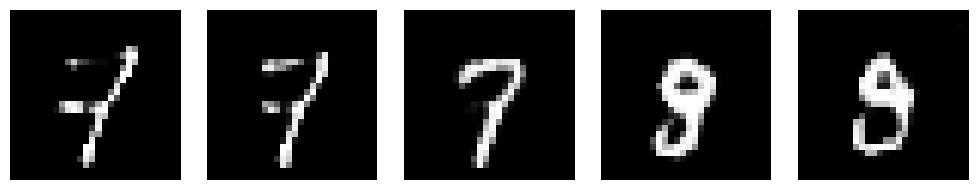

In [22]:
# Load the saved generator model
z_dim = latent_dim
generator = Generator(latent_dim)
generator.load_state_dict(torch.load("/content/drive/My Drive/lsca_gan_model_0.0.pth", map_location=torch.device('cpu')))
generator.eval()

# Sample a base latent vector
z_base = torch.randn(1, z_dim, 1, 1)

# Manipulate the latent vector along a specific direction
direction = torch.randn_like(z_base)  # Replace with a learned direction vector if available
alphas = torch.linspace(-3, 3, steps=5)  # Range of manipulations

# Generate images from manipulated latent vectors
z_variations = torch.cat([z_base + alpha * direction for alpha in alphas], dim=0)
with torch.no_grad():
    fake_images = generator(z_variations)

show_images(fake_images, nrow=len(alphas))


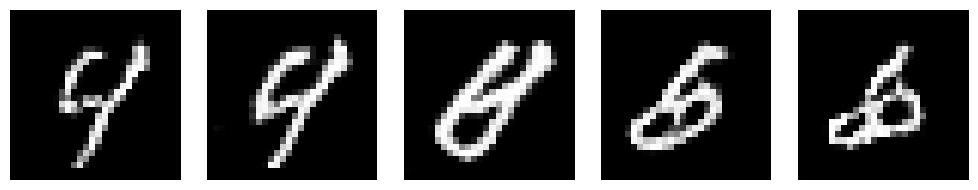

In [23]:
# Load the saved generator model
z_dim = latent_dim
generator = Generator(latent_dim)
generator.load_state_dict(torch.load("/content/drive/My Drive/lsca_gan_model_1.0.pth", map_location=torch.device('cpu')))
generator.eval()

# Sample a base latent vector
z_base = torch.randn(1, z_dim, 1, 1)

# Manipulate the latent vector along a specific direction
direction = torch.randn_like(z_base)  # Replace with a learned direction vector if available
alphas = torch.linspace(-3, 3, steps=5)  # Range of manipulations

# Generate images from manipulated latent vectors
z_variations = torch.cat([z_base + alpha * direction for alpha in alphas], dim=0)
with torch.no_grad():
    fake_images = generator(z_variations)

show_images(fake_images, nrow=len(alphas))


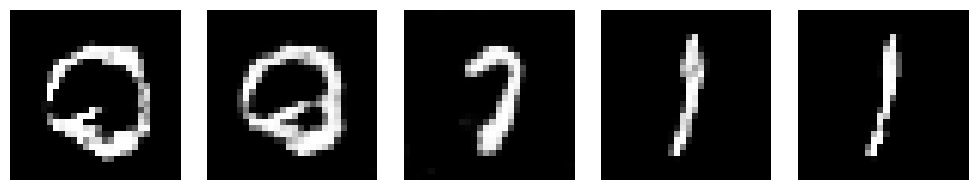

In [24]:
# Load the saved generator model
z_dim = latent_dim
generator = Generator(latent_dim)
generator.load_state_dict(torch.load("/content/drive/My Drive/lsca_gan_model_2.0.pth", map_location=torch.device('cpu')))
generator.eval()

# Sample a base latent vector
z_base = torch.randn(1, z_dim, 1, 1)

# Manipulate the latent vector along a specific direction
direction = torch.randn_like(z_base)  # Replace with a learned direction vector if available
alphas = torch.linspace(-3, 3, steps=5)  # Range of manipulations

# Generate images from manipulated latent vectors
z_variations = torch.cat([z_base + alpha * direction for alpha in alphas], dim=0)
with torch.no_grad():
    fake_images = generator(z_variations)

show_images(fake_images, nrow=len(alphas))


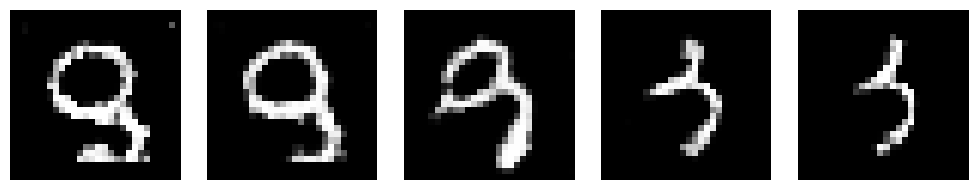

In [25]:
# Load the saved generator model
z_dim = latent_dim
generator = Generator(latent_dim)
generator.load_state_dict(torch.load("/content/drive/My Drive/lsca_gan_model_3.0.pth", map_location=torch.device('cpu')))
generator.eval()

# Sample a base latent vector
z_base = torch.randn(1, z_dim, 1, 1)

# Manipulate the latent vector along a specific direction
direction = torch.randn_like(z_base)  # Replace with a learned direction vector if available
alphas = torch.linspace(-3, 3, steps=5)  # Range of manipulations

# Generate images from manipulated latent vectors
z_variations = torch.cat([z_base + alpha * direction for alpha in alphas], dim=0)
with torch.no_grad():
    fake_images = generator(z_variations)

show_images(fake_images, nrow=len(alphas))
